# Variational Autoencoders

We have seen 2 applications for autoencoders : To learn a compressed representation of data and for removing noise within data, both on unlabelled data.

Another application (this one too, requiring no labelled data) is for generating strucutred data. In our case, we want to generate handwritten digits.

For this, we need to modify the normal autoencoder architecture by making the learned compressed representation a random gaussian variable with a mean and variance. The ean and variance are what is learned by the encoder network. A value is sampled from this and then fed to the decoder. This seemingly unnecessary step and addition of randomness is to make it possible for us to tweak the internal state to generate new values. In the case of the normal autoencoder, only some combinations of internal state might be used by the network for representations of valid data (in our case, legitimate looking handwritten digits). The rest of the feature space is wasted. 

By randomly sampling from the encoded random variable, we encourage the decoder to learn to decode a wider and more continuous range from its input.

Another step that we need to do to create good generative models is to ensure that the encoded state is well behaved and predictable. The network could map valid data to some space in feature space, and when we give it inputs outside this space, it generates just random incomprhensible noise, because the decoder simply hasnt learned with that representation. The solution is to add a term to the loss that will encourage the encoder network to generate the mean and divergence in a particular region. The common choice for this standard is the standard normal distribution. KL divergence is used to measure the difference between the current encoding (mean and variance) and the standard normal distribution and penalizes large changes that are observed over the whole batch.

As a result, we can generate some random vector using a standard normal noise generator (```np.random.randn```) and feed it to the input of the decoder and expect (hope) to get a well-behaved output.

---

In [1]:
%matplotlib inline
import os
import copy
import torch
import codecs
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets
from torchvision import transforms
import torch.nn.functional as F

from tqdm import tqdm

print(torch.__version__)

1.7.0


In [2]:
# Converting images to tensors
transform = transforms.Compose([transforms.ToTensor()])
batchsize = 20000

# Loading training and test sets
TrainSet    = datasets.MNIST(root="../downloads/MNIST", train=True, download=True, transform=transform)
TrainLoader = torch.utils.data.DataLoader(TrainSet, batch_size=batchsize, shuffle=True, num_workers=0)
TestSet     = datasets.MNIST(root="../downloads/MNIST", train=False, download=True, transform=transform)
TestLoader  = torch.utils.data.DataLoader(TrainSet, batch_size=batchsize, shuffle=True, num_workers=0)

classes    = ('zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine')

In [3]:
use_gpu = torch.cuda.is_available()
if use_gpu:
    print("GPU is available")
    device = "cuda"
else:
    print("GPU is not available")
    device = "cpu"

GPU is available


The encoder learns a probability distribution q(z|x) and decoder learns p(x|z).
- x = Input/Output
- z = Encoding

Variational autoencoders are used as generative models.

The KL loss is used to encourage the encoder to learn distributions similar to the standard normal. This
is to make it possible to sample during inference and hope to get a valid output. Otherwise, the distribution
learned by encoder and in turn, the decoder could be really far off and unknown.

Actual KL loss is :

```Expectation(log(p(x)/q(x))) = sum(p(x) * log(p(x)/q(x)))```
(p-wanted, q-actual)

For p = Normal distribution and q = Gaussian distribution (mean, var) , it becomes

```sum(var**2 + mean**2 - log(var) - 1```

Another term, the reconstruction loss is used to encourage faithfull reconstruction of input by decoder. This 

In [88]:
class var_autoencoder(nn.Module):
    def __init__(self, hidden_dim=100, latent_dim=10):
        super(var_autoencoder, self).__init__()
        
        self.encoder  = nn.Sequential(nn.Linear(28*28, hidden_dim),      nn.ReLU())
        self.decoder1 = nn.Sequential(nn.Linear(latent_dim, hidden_dim), nn.ReLU())
        self.decoder2 = nn.Sequential(nn.Linear(hidden_dim, 28*28),      nn.Sigmoid())
        
        self.fc_mu   = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar  = nn.Sequential(nn.Linear(hidden_dim, latent_dim), nn.ReLU())
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return mu + eps*std
        
        return sample
    
    def forward(self, X):
        mean, logvar = self.encode(X)
        
        x    = self.reparameterize(mean, logvar)
        
        x    = self.decode(x)
        return x, mean, logvar
    
    def encode(self, X):
        x = self.encoder(X)
        return self.fc_mu(x), self.fc_logvar(x)
    
    def decode(self, X):
        x = self.decoder1(X)
        return self.decoder2(x)

net = var_autoencoder(hidden_dim=200, latent_dim=50)
print(net)

net = net.double().to(device)

init_weights = copy.deepcopy(net.encoder[0].weight.data)

var_autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=200, bias=True)
    (1): ReLU()
  )
  (decoder1): Sequential(
    (0): Linear(in_features=50, out_features=200, bias=True)
    (1): ReLU()
  )
  (decoder2): Sequential(
    (0): Linear(in_features=200, out_features=784, bias=True)
    (1): Sigmoid()
  )
  (fc_mu): Linear(in_features=200, out_features=50, bias=True)
  (fc_logvar): Linear(in_features=200, out_features=50, bias=True)
)


In [89]:
def custom_loss(bce_loss, mu, logvar):
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return bce_loss + kld_loss

In [90]:
def model_init(m):
    if(isinstance(m, nn.Linear)):
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)
        
#net.apply(model_init)

In [91]:
criterion = nn.BCELoss(reduction='sum')
optimizer = optim.Adam(net.parameters(), lr=1e-3)

  0%|          | 0/20 [00:00<?, ?it/s]

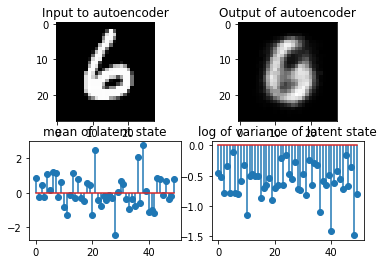

Loss : 167.811450


  5%|▌         | 1/20 [00:05<01:35,  5.04s/it]

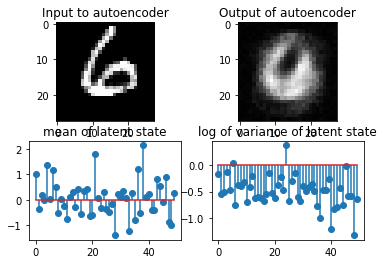

Loss : 167.344100


 10%|█         | 2/20 [00:10<01:30,  5.03s/it]

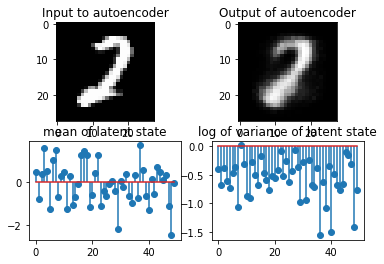

Loss : 166.590500


 15%|█▌        | 3/20 [00:15<01:25,  5.01s/it]

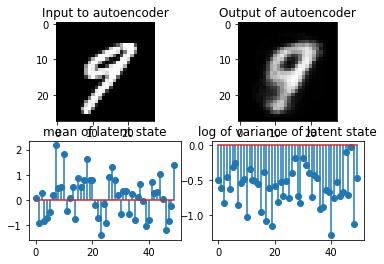

Loss : 165.120050


 20%|██        | 4/20 [00:20<01:21,  5.06s/it]

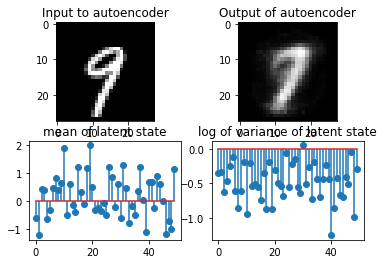

Loss : 164.594600


 25%|██▌       | 5/20 [00:25<01:15,  5.05s/it]

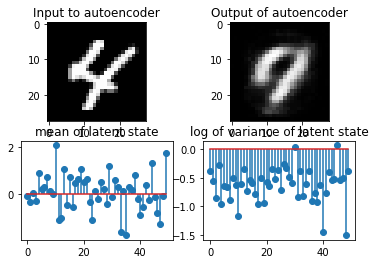

Loss : 163.904750


 30%|███       | 6/20 [00:30<01:11,  5.10s/it]

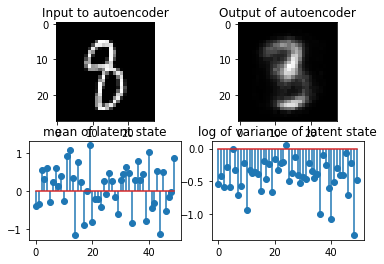

Loss : 162.821200


 35%|███▌      | 7/20 [00:35<01:06,  5.14s/it]

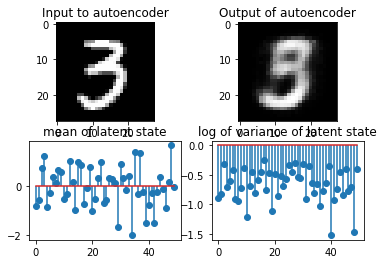

Loss : 162.648950


 40%|████      | 8/20 [00:40<01:01,  5.15s/it]

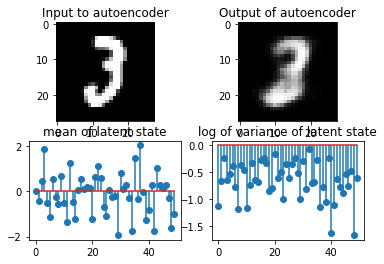

Loss : 161.609200


 45%|████▌     | 9/20 [00:46<00:57,  5.21s/it]

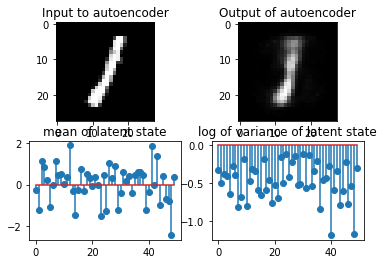

Loss : 160.190500


 50%|█████     | 10/20 [00:51<00:51,  5.14s/it]

 Iteration  10/ 20, loss was 9642101.000000


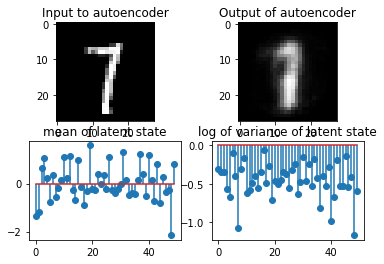

Loss : 160.247200


 55%|█████▌    | 11/20 [00:56<00:46,  5.13s/it]

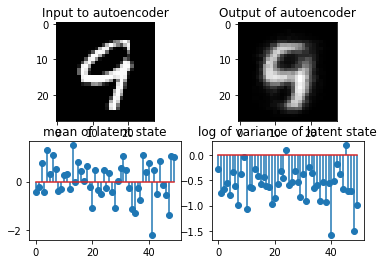

Loss : 159.300350


 60%|██████    | 12/20 [01:01<00:40,  5.10s/it]

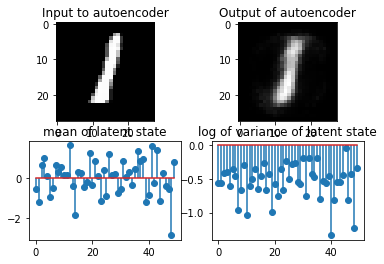

Loss : 159.154050


 65%|██████▌   | 13/20 [01:06<00:35,  5.11s/it]

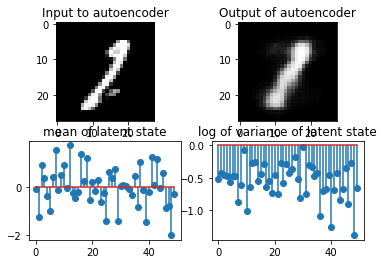

Loss : 158.339200


 70%|███████   | 14/20 [01:11<00:30,  5.06s/it]

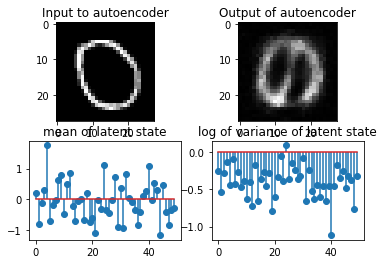

Loss : 157.930000


 75%|███████▌  | 15/20 [01:16<00:25,  5.15s/it]

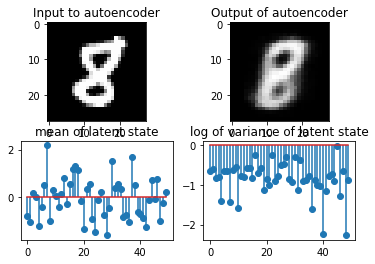

Loss : 157.108050


 80%|████████  | 16/20 [01:21<00:20,  5.17s/it]

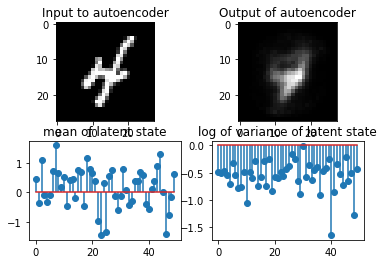

Loss : 156.788600


 85%|████████▌ | 17/20 [01:27<00:15,  5.19s/it]

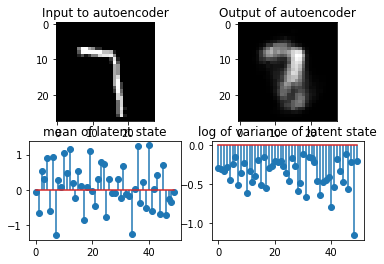

Loss : 156.226050


 90%|█████████ | 18/20 [01:32<00:10,  5.18s/it]

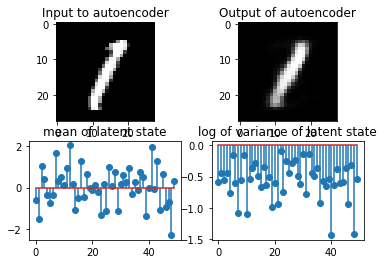

Loss : 155.717400


 95%|█████████▌| 19/20 [01:37<00:05,  5.20s/it]

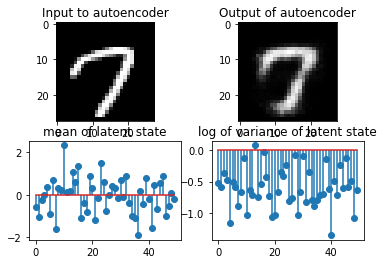

Loss : 155.320600


100%|██████████| 20/20 [01:42<00:00,  5.13s/it]

 Iteration  20/ 20, loss was 9300392.000000
Finished training


In [122]:
iterations = 20

# Set this to true to view the input, noised input, and output of the autoencoder for each epoch
debug = True

sparcity = 0

for epoch in tqdm(range(iterations)):
    runningLoss = 0
    for i, data in enumerate(TrainLoader):
        inputs, labels = data
        inputs = inputs.double().view(-1,1,28*28)
        inputs = inputs.to(device)
        
        # Resetting gradients from previous run
        optimizer.zero_grad()

        # Forward pass
        outputs, mean, logvar = net(inputs)
        
        # Computing loss (Mean Square Error + L1 penality to force sparcity)
        loss = criterion(outputs, inputs)
        loss = custom_loss(loss, mean, logvar)
        
        # Backpropagate the loss
        loss.backward()

        # Stockastic gradient descent
        optimizer.step()
    
        runningLoss += int(loss.cpu().item())

        # Display input and output of autoencoder for debugging (only for the first image for each epoch)
        if(debug and i == 0):
            plt.subplot(221)
            plt.imshow(inputs[0].view(28,28).cpu(), cmap='gray')
            plt.title("Input to autoencoder")

            plt.subplot(222)
            plt.imshow(outputs[0].view(28,28).cpu().detach(), cmap='gray')
            plt.title("Output of autoencoder")
            
            plt.subplot(223)
            plt.stem(mean[0].view(-1).cpu().detach(), use_line_collection=True)
            plt.title('mean of latent state')
            
            plt.subplot(224)
            plt.stem(logvar[0].view(-1).cpu().detach(), use_line_collection=True)
            plt.title('log of variance of latent state')
            
            plt.show()

            print("Loss : %f"%(runningLoss/batchsize))

    if(epoch % 10 == 9):        
        print(" Iteration %3d/%3d, loss was %f"%(epoch+1, iterations, runningLoss))

print("Finished training")

# References

https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf
https://debuggercafe.com/getting-started-with-variational-autoencoder-using-pytorch/


Test set index number : 11396
torch.Size([1, 28, 28])


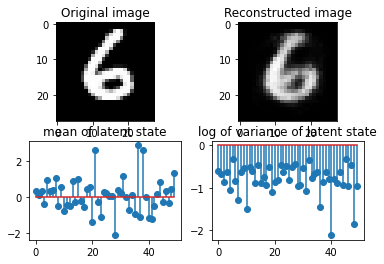


Test set index number : 64
torch.Size([1, 28, 28])


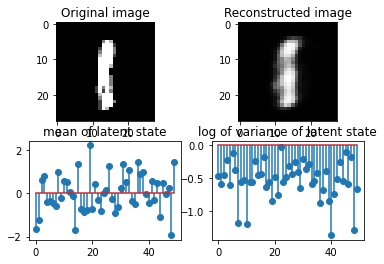


Test set index number : 19567
torch.Size([1, 28, 28])


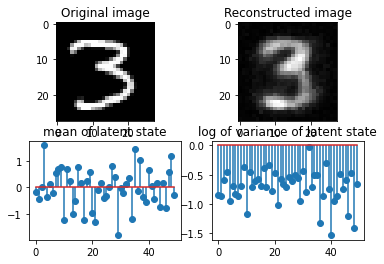


Test set index number : 6472
torch.Size([1, 28, 28])


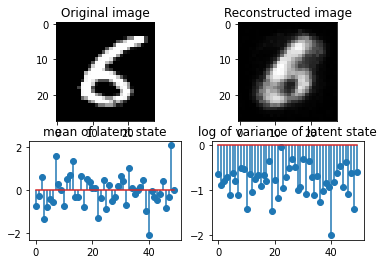


Test set index number : 12391
torch.Size([1, 28, 28])


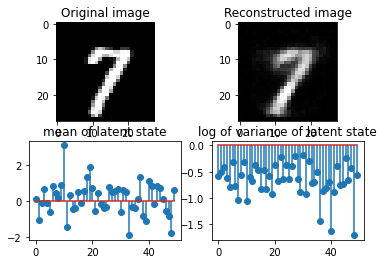


Test set index number : 8638
torch.Size([1, 28, 28])


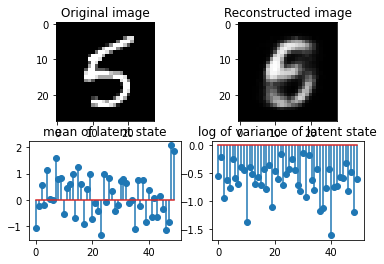


Test set index number : 19030
torch.Size([1, 28, 28])


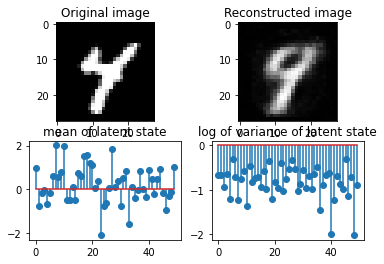


Test set index number : 8856
torch.Size([1, 28, 28])


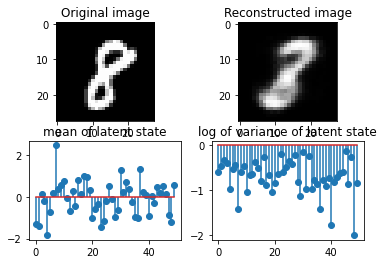


Test set index number : 7579
torch.Size([1, 28, 28])


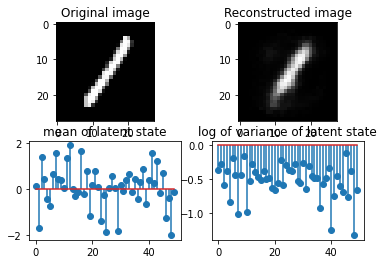


Test set index number : 6621
torch.Size([1, 28, 28])


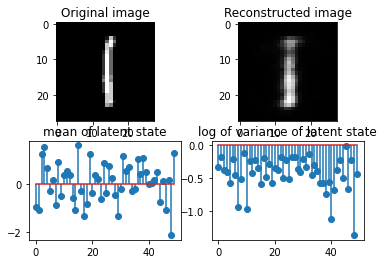

In [123]:
TestImages, _ = list(TrainLoader)[0]
indices = np.random.uniform(0, TestImages.shape[0], size=10)

for i in indices:
    print()
    print("Test set index number : %d"%i)

    test_img = TestImages[int(i)]

    print(test_img.shape)

    out, mean, logvar = net((test_img.clone().view(-1,1,28*28).double().to(device)))
    output_img = (out.data*255).byte()
    output_img = output_img.view(-1, 28, 28)

    if device == "cuda":
        output_img = output_img.cpu()
        noised_img = noised_img.cpu()

    test_img = test_img.view(-1, 28, 28)
    noised_img = noised_img.view(-1, 28, 28)

    plt.subplot(221)
    img = np.array(test_img.numpy())[0]
    plt.title("Original image")
    plt.imshow(img, cmap="gray")

    plt.subplot(222)
    out_img = np.array(output_img.numpy())[0]
    plt.title("Reconstructed image")
    plt.imshow(out_img, cmap="gray")
    
    plt.subplot(223)
    plt.stem(mean[0].view(-1).cpu().detach(), use_line_collection=True)
    plt.title('mean of latent state')
            
    plt.subplot(224)
    plt.stem(logvar[0].view(-1).cpu().detach(), use_line_collection=True)
    plt.title('log of variance of latent state')
            
    plt.show()

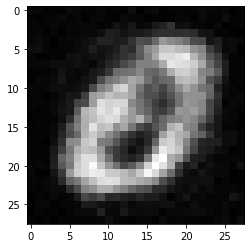

In [142]:
inp = np.random.randn(50).astype('float32')
out = net.decode(torch.Tensor(inp).type(torch.float64).to(device)).view(28,28).cpu().detach()
plt.imshow(out, cmap='gray')